## Key Topics Extraction and Contextual Sentiment of Hotel Reviews

## 1. Preprocess

In [1]:
import os
from os import listdir
import pandas as pd
#!pip install plotly
import plotly.graph_objs as go
df = pd.read_csv('hotel-reviews/Datafiniti_Hotel_Reviews_Jun19.csv', header=0)
df.columns

Index(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'sourceURLs', 'websites'],
      dtype='object')

In [2]:
df.drop(columns=['id','country','dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'keys', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username', 'sourceURLs', 'websites'], inplace = True)
df = df.rename(index=str, columns={'reviews.rating':'rating', 'reviews.sourceURLs': 'reviews_sourceURLs', 'reviews.text':'reviews_text', 'reviews.title': 'reviews_title'})

In [3]:
df.head()

,city,latitude,longitude,name,postalCode,province,rating,reviews_sourceURLs,reviews_text,reviews_title
0,Goleta,34.44178,-119.81979,Best Western Plus South Coast Inn,93117,CA,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel
1,Carmel by the Sea,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,4,https://www.tripadvisor.com/Hotel_Review-g3217...,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel
2,Carmel by the Sea,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,3,https://www.tripadvisor.com/Hotel_Review-g3217...,"Parking was horrible, somebody ran into my ren...",Business
3,Carmel by the Sea,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,5,https://www.tripadvisor.com/Hotel_Review-g3217...,Not cheap but excellent location. Price is som...,Very good
4,Carmel by the Sea,36.55722,-121.92194,Best Western Carmel's Town House Lodge,93921,CA,2,https://www.tripadvisor.com/Hotel_Review-g3217...,If you get the room that they advertised on th...,Low chance to come back here


## 2. Amenity Extraction

In [4]:
import nltk.data
from os import listdir
from os.path import isfile, join
from nltk.util import bigrams 
from nltk.tokenize import TreebankWordTokenizer
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
treebank_tokenizer = TreebankWordTokenizer()
import numpy as np
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
#stop_words = stopwords.words('english')

In [5]:
#check if the element passed in is a float
def isfloat(value):
  try:
    float(value)
    #return true if it can be cast to a float
    return True
  except ValueError:
    return False

In [136]:
stop_words = ['in','of','at','a','the']
def process_text(text):
    #tokenzie the text as sentences
    punkt_sentences = sentence_tokenizer.tokenize(text)
    #tokenize as lists of sentence lists of words
    sentences_words = [treebank_tokenizer.tokenize(sentence) for sentence in punkt_sentences]
    #get a list of words without punctuations
    tokens = [word for sentence in sentences_words for word in sentence if word == 'A/C' or word.isalpha()]
    #lemmatization 
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    #remove the stopwords
    tokens = [word for word in tokens if not word in stop_words]
    #remove numbers
    tokens = [word.lower() for word in tokens if isfloat(word == False)]
    #generate bigrams
    bigrams = nltk.bigrams(tokens)
    return tokens,list(bigrams)

### Get the sentiment

In [137]:
from nltk.corpus import sentiwordnet as swn
def senti(bigram):
    #TODO 'have'
    if bigram.lower() == 'have' or bigram.lower() == 'free':
        return True
    happy = swn.senti_synsets(bigram)
    ps = 0
    ns = 0
    for i in list(happy):
        ps += i.pos_score()
        ns += i.neg_score()
    return max(ps,ns) == ps


In [194]:
amenity_list = ['A/C','fan','parking','coffee','breakfast','pool','clean',
             'kitchen','internet','computer','recreation','exercise',
             'vending','locker','dryer','laundry','location','space','room','staff']
def amenity_extraction_hotel(hotel):
    amenities = {}
    hotel_item = []
    for i in df['name']:
        if hotel in i:
            hotel_item.append(True)
        else:
            hotel_item.append(False)
    
    for text in df[hotel_item]['reviews_text']:
        tokens,bigrams = process_text(clean_text(text))
        for word in tokens:
            for amenity in amenity_list:
                if word.lower() == amenity.lower():
                    if word not in amenities.keys():
                        amenities.update({word:0})
                    for bi in bigrams:
                        if bi[1].lower() == word.lower():
                            #print(bi[0])
                            #print(senti(bi[0]))
                            if senti(bi[0]):
                                #print(bi[0])
                                amenities[word] += 1
                            else:
                                #print(bi[0])
                                amenities[word] -= 1               
    return sorted(amenities.items(), key=lambda x: x[1],reverse = True) 

In [196]:
amenity_extraction_hotel('Hyatt')

[('room', 1264),
 ('staff', 386),
 ('location', 341),
 ('breakfast', 322),
 ('clean', 210),
 ('space', 86),
 ('kitchen', 40),
 ('coffee', 26),
 ('parking', 21),
 ('pool', 20),
 ('internet', 11),
 ('computer', 10),
 ('laundry', 2),
 ('dryer', 2),
 ('recreation', 1),
 ('exercise', 1),
 ('fan', 0)]

### Extract amenties for all the hotels

In [10]:
#hotel_amenities = {}
#for hotel in df['name'].unique():
    #amenities = amenity_extraction_hotel(hotel)
    #hotel_amenities.update({hotel:amenities})

In [58]:
def get_hotel_by_needs(city,amenity):
    hotels = np.unique(df[df['city'] == city]['name'])
    hotel_a_score = {}
    for hotel in hotels:
        hotel_a_score.update({hotel:0})
        amenities = amenity_extraction_hotel(hotel)
        for a in amenities:
            if a[0] == amenity:
                hotel_a_score[hotel] = a[1]
    return sorted(hotel_a_score.items(), key=lambda x: x[1],reverse = True) 
                

In [62]:
get_hotel_by_needs('San Diego','breakfast')

[('Hampton Inn San Diego Del Mar', 62),
 ('Best Western Mission Bay', 58),
 ('Quality Suites San Diego SeaWorld Area', 55),
 ('Best Western Plus Bayside Inn', 47),
 ('Ocean Park Inn', 42),
 ('Best Western San Diego/Miramar Hotel', 41),
 ('Best Western Plus Hacienda Hotel Old Town', 34),
 ('Best Western Yacht Harbor Hotel', 34),
 ('Best Western Seven Seas', 24),
 ('Hampton Inn San Diego/Mission Valley', 19),
 ('Rodeway Inn San Diego Near Qualcomm Stadium', 19),
 ('Best Western Lamplighter Inn Suites at SDSU', 13),
 ('SpringHill Suites San Diego Downtown/Bayfront', 11),
 ('Best Western Cabrillo Garden Inn', 10),
 ('Ramada Limited San Diego/Near SeaWorld', 10),
 ('Courtyard San Diego Rancho Bernardo', 7),
 ('Hilton Garden Inn San Diego Mission Valley/stadium', 7),
 ('Pacific Shores Inn', 7),
 ('Hilton Garden Inn San Diego Rancho Bernardo', 6),
 ('The Westin San Diego', 6),
 ('Four Points by Sheraton San Diego - SeaWorld', 4),
 ('Holiday Inn San Diego-Bayside', 2),
 ('Kimpton Solamar Hotel

## 3. More

In [11]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["reviews_text"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [201]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stop_words
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["reviews_text"].apply(lambda x: clean_text(x))


In [202]:
clean_text("We booked this hotel because we had a wedding. It was impeccable,"+
           "comfortable, and they had an excellent breakfast. Good swimming pool. No A/C")

'we book this hotel because we have wed it be impeccable,comfortable and they have an excellent breakfast good swimming pool no a/c'

In [189]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["reviews_text"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["reviews_text"].apply(lambda x: len(x.split(" ")))

In [14]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [15]:
#transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [28]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)
#reviews_tfidf_df.columns

In [77]:
# show is_bad_review distribution
reviews_df["is_bad_review"] = reviews_df['rating'] <= 2
reviews_df["is_bad_review"].value_counts(normalize = True)

False    0.8879
True     0.1121
Name: is_bad_review, dtype: float64

In [210]:
# wordcloud function
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    

# print wordcloud
def wordcloud_hotel(hotel):
    show_wordcloud(reviews_df[reviews_df['name'] == hotel]['review_clean'].values)

In [211]:
dic = {}
for name in np.unique(df['name']):
    dic.update({name:0})
    for i in df['name']:
        if i == name:
            dic[name] += 1
dic = sorted(dic.items(), key=lambda x: x[1],reverse = True)
#print(dic)

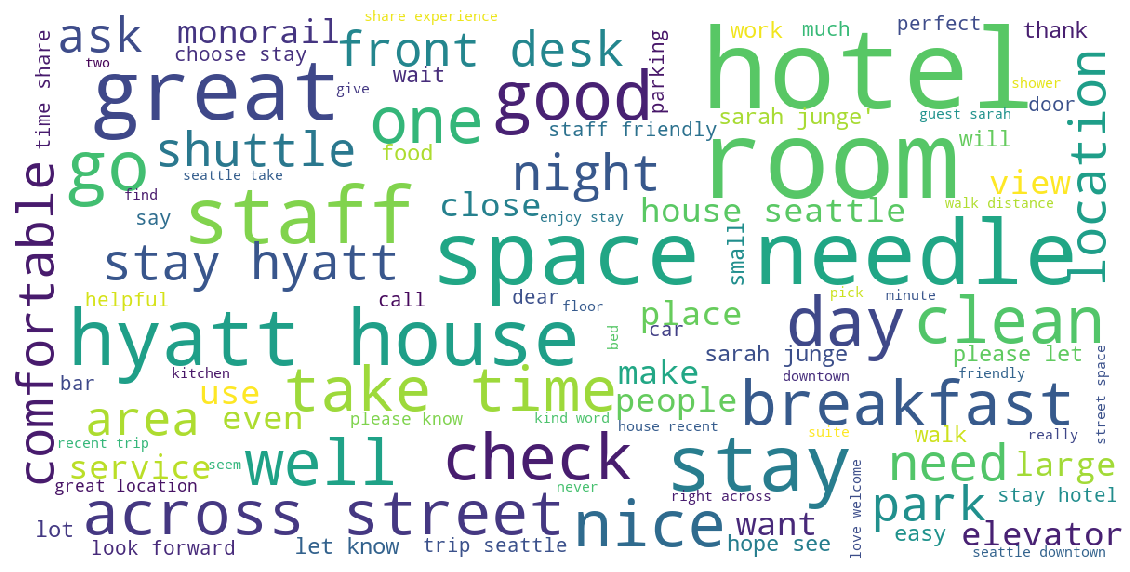

[('room', 900),
 ('staff', 266),
 ('breakfast', 215),
 ('location', 162),
 ('space', 162),
 ('clean', 83),
 ('kitchen', 44),
 ('coffee', 20),
 ('parking', 18),
 ('internet', 2),
 ('exercise', 2),
 ('dryer', 2),
 ('fan', -2),
 ('pool', -2)]

In [212]:
#hotelnum = 400
#wordcloud_hotel(df['name'][hotelnum])
#print(amenity_extraction_hotel(df['name'][hotelnum]))
#print(df['name'][hotelnum])
wordcloud_hotel('Hyatt House Seattle/Downtown')
amenity_extraction_hotel('Hyatt House Seattle/Downtown')
#print('Hyatt House Seattle/Downtown')

In [81]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["reviews_text",'name', "neg"]].head(10)


,reviews_text,name,neg
3636,The staff here is horrible and the manager suc...,Knights Inn Metairie,0.392
6977,"The pictures were dirty with brown stuff, the ...",Econo Lodge,0.375
4132,"Infected of fleas and thumbtacks, bedbags infe...",Hotel Occidental,0.358
6591,Very upset with my stay at this hotel. Room is...,Habitat Residence,0.343
2334,"There is no fridge, no microwave, no hanger. T...",Days Inn By Wyndham Orlando/International Drive,0.336
4984,Room was smelly and dark Bathroom was shocking...,Hotel Rex San Francisco,0.331
8718,"Employees rude, not helpful. Drugs run amuck h...",Intown Suites Piedmont,0.329
2269,The hotel is very rundown. I was very disappoi...,Microtel Inn & Suites By Wyndham Augusta/River...,0.317
4481,"Ice machine broken, telephone broken, ice buck...",Orlando Continental Plaza Hotel,0.316
3876,Rude clerk at check in. After a long wait! Roo...,Delano Las Vegas,0.310


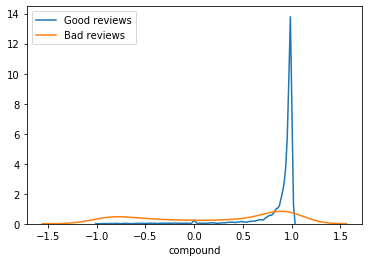

In [82]:
# plot sentiment distribution for positive and negative reviews
import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)


In [83]:
reviews_df.columns

Index(['city', 'latitude', 'longitude', 'name', 'postalCode', 'province',
       'rating', 'reviews_sourceURLs', 'reviews_text', 'reviews_title',
       ...
       'word_young', 'word_your', 'word_youre', 'word_yours', 'word_yr',
       'word_yummy', 'word_zaza', 'word_zephyr', 'word_zero', 'word_zoo'],
      dtype='object', length=3582)

In [84]:
# feature selection
label = "is_bad_review"

ignore_cols = [label, "reviews_text", "review_clean",'city','name','postalCode','province',
              'reviews_sourceURLs','reviews_title','rating']
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [85]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
5,compound,0.049497
4,pos,0.048732
2,neg,0.037352
12,doc2vec_vector_4,0.018763
9,doc2vec_vector_1,0.016190
3,neu,0.015214
905,word_dirty,0.013482
275,word_bad,0.008583
2913,word_sorry,0.008581
2872,word_smell,0.007222


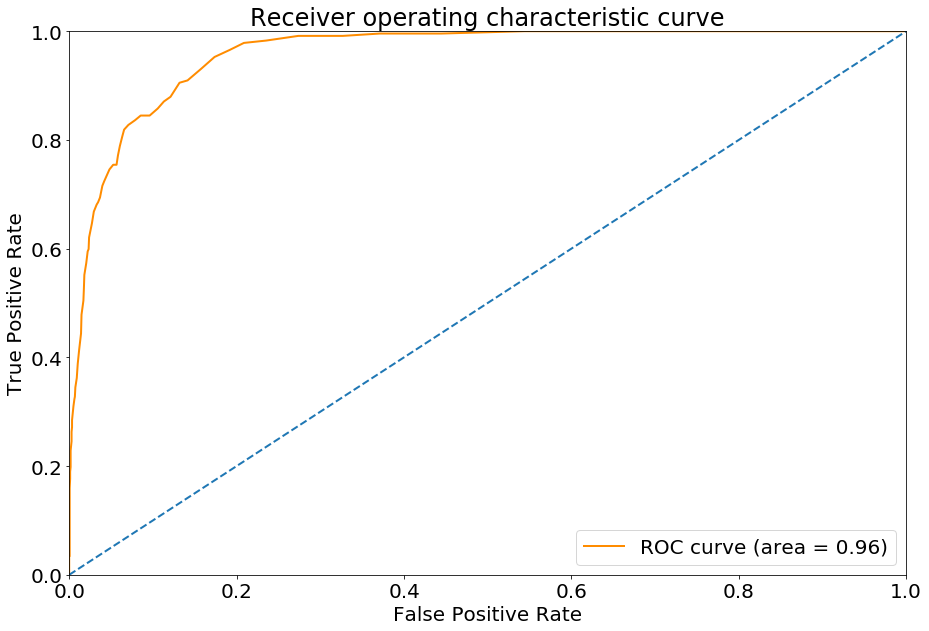

In [129]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.rcParams.update({'font.size': 10})
plt.show()

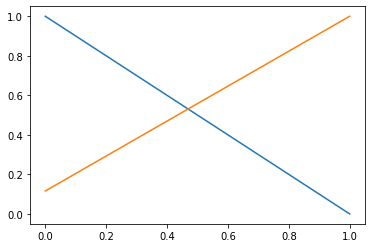

0.3164826595323028


In [118]:
from sklearn.metrics import confusion_matrix
precision_list = []
threshold_list = []
for threshold in np.linspace(0,1,100):
    average_p = average_precision_score(y_test, (X_test['neg']>threshold))
    precision_list.append(average_p)
    threshold_list.append(threshold)

p, r, _ = precision_recall_curve(y_test,(X_test['neg']>np.argmax(precision_list)))
plt.plot(r)
plt.plot(p)
plt.show()
print(max(precision_list))


0.7629433416564614


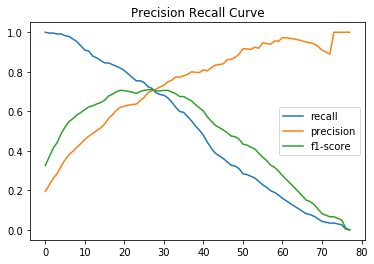

In [119]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
#from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

print(average_precision)
plt.plot(recall)
plt.plot(precision)
plt.title('Precision Recall Curve')
plt.plot(2*precision*recall/(precision+recall))
plt.legend(['recall','precision','f1-score'])
plt.show()
